**Important: This notebook will only work with fastai-0.7.x. Do not try to run any fastai-1.x code from this path in the repository because it will load fastai-0.7.x**

# Random Forest Model interpretation

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

from fastai.imports import *
from fastai.structured import *
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics

In [3]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [4]:
set_plot_sizes(12,14,16)

## Load in our data from last lesson

In [5]:
PATH = "./"

df_raw = pd.read_feather('tmp/lunchbox-raw')
df_trn, y_trn, nas = proc_df(df_raw, 'responsevalue')

In [6]:
df_raw.head()

responsevalue week  soldout        name  kcal remarks event  payday  \
0             90    月        0    厚切りイカフライ   408      NA    NA   False   
1            101    火        1     手作りヒレカツ   408      NA    NA   False   
2            118    水        0  白身魚唐揚げ野菜あん   408      NA    NA   False   
3            120    木        1      若鶏ピリ辛焼   408      NA    NA   False   
4            130    金        1    ビッグメンチカツ   408      NA    NA   False   

  weather  precipitation  ...  saleDayofweek  saleDayofyear  saleIs_month_end  \
0      快晴            0.0  ...              0            322             False   
1      快晴            0.0  ...              1            323             False   
2      快晴            0.0  ...              2            324             False   
3      快晴            0.0  ...              3            325             False   
4      快晴            0.0  ...              4            326             False   

   saleIs_month_start  saleIs_quarter_end  saleIs_quarter_start  \
0               False               False                 False   
1               False               False                 False   
2               False               False                 False   
3               False               False                 False   
4               False               False                 False   

   saleIs_year_end  saleIs_year_start  saleElapsed  kcal_na  
0            False              False   1384732800     True  
1            False              False   1384819200     True  
2            False              False   1384905600     True  
3            False              False   1384992000     True  
4            False              False   1385078400     True  

[5 rows x 25 columns]

In [7]:
def split_vals(a,n): return a[:n], a[n:]
n_valid = 40 # same as test set sample number
n_trn = len(df_trn)-n_valid
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)
raw_train, raw_valid = split_vals(df_raw, n_trn)

In [8]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

# Confidence based on tree variance

For model interpretation, there's no need to use the full dataset on each tree - using a subset will be both faster, and also provide better interpretability (since an overfit model will not provide much variance across trees).

In [9]:
# Set to 167 (207 train samples (November 18, 2013 to September 30, 2014) - 40 test sample)
set_rf_samples(167)

In [10]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
# Way too few samples we have, so omit min_samples_leaf=3, max_features=0.5
#m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[5.9031897903251265, 12.964454409075609, 0.9654880991578292, 0.5265267703088137, 0.7621528572985927]


We saw how the model averages predictions across the trees to get an estimate - but how can we know the confidence of the estimate? One simple way is to use the standard deviation of predictions, instead of just the mean. This tells us the *relative* confidence of predictions - that is, for rows where the trees give very different results, you would want to be more cautious of using those results, compared to cases where they are more consistent. Using the same example as in the last lesson when we looked at bagging:

In [11]:
%time preds = np.stack([t.predict(X_valid) for t in m.estimators_])
np.mean(preds[:,0]), np.std(preds[:,0])

CPU times: user 48.9 ms, sys: 1.07 ms, total: 50 ms
Wall time: 49.3 ms


(57.8, 7.861933604400384)

When we use python to loop through trees like this, we're calculating each in series, which is slow! We can use parallel processing to speed things up:

In [12]:
def get_preds(t): return t.predict(X_valid)
%time preds = np.stack(parallel_trees(m, get_preds))
np.mean(preds[:,0]), np.std(preds[:,0])

CPU times: user 35.1 ms, sys: 52.7 ms, total: 87.8 ms
Wall time: 134 ms


(57.8, 7.861933604400384)

We can see that different trees are giving different estimates this this auction. In order to see how prediction confidence varies, we can add this into our dataset.

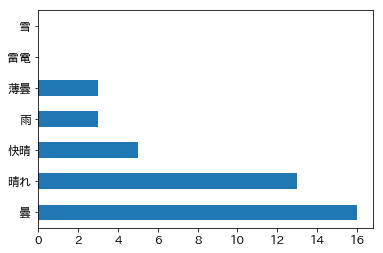

In [20]:
x = raw_valid.copy()
x['pred_std'] = np.std(preds, axis=0)
x['pred'] = np.mean(preds, axis=0)

  week  responsevalue       pred   pred_std
0    月         56.125  65.056250   8.353979
1    火         55.250  58.009375   8.004492
2    水         56.125  58.178125   7.996455
3    木         54.500  57.753125   6.727437
4    金         69.250  78.606250  13.705923


4    0.174362
1    0.137986
2    0.137448
0    0.128412
3    0.116486
dtype: float64

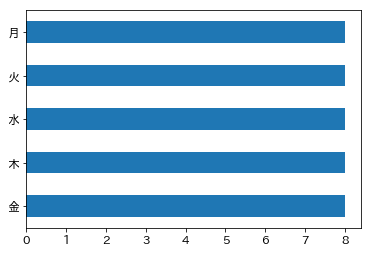

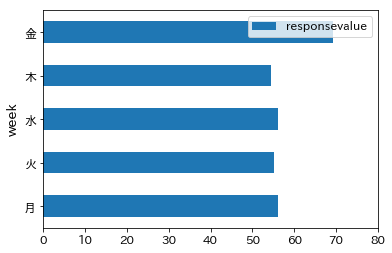

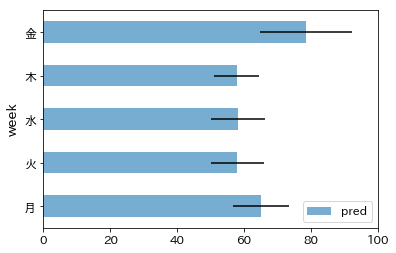

In [68]:
flds = ['week', 'responsevalue', 'pred', 'pred_std']
summ = x[flds].groupby('week', as_index=False).mean()
print(summ) # Without print(), it won't get printed together with other matplotlib graphs

x.week.value_counts().plot.barh()

#'~' means negation, the following code gets rid of:
# NaN in numeric arrays, None or NaN in object arrays, NaT in datetimelike entries in 'responsevalue' column
summ = summ[~pd.isnull(summ.responsevalue)]
summ.plot('week', 'responsevalue', 'barh', xlim=(0,80))

summ.plot('week', 'pred', 'barh', xerr='pred_std', alpha=0.6, xlim=(0,100))

(summ.pred_std/summ.pred).sort_values(ascending=False)

soldout  responsevalue      pred  pred_std
0        0      56.428571  63.66875  8.688438
1        1      62.500000  63.17500  9.585834

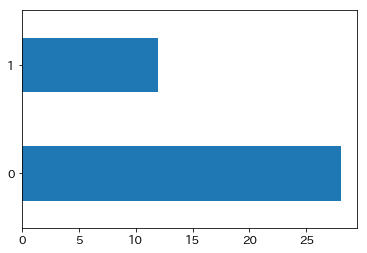

In [56]:
x.soldout.value_counts().plot.barh()
flds = ['soldout', 'responsevalue', 'pred', 'pred_std']
summ = x[flds].groupby('soldout', as_index=False).mean()
summ

name  responsevalue    pred   pred_std
0               いか天ぷら            NaN     NaN        NaN
1             かじきの甘辛煮            NaN     NaN        NaN
2         きのこソースハンバーグ            NaN     NaN        NaN
3           さっくりメンチカツ            NaN     NaN        NaN
4            さわら焼味噌掛け            NaN     NaN        NaN
5              さんま辛味焼            NaN     NaN        NaN
6         たっぷりベーコンフライ            NaN     NaN        NaN
7    ひやしたぬきうどん・炊き込みご飯            NaN     NaN        NaN
8         ぶりレモンペッパー焼き           54.0  57.450  10.022350
9         ますのマスタードソース            NaN     NaN        NaN
10      やわらかロースのサムジョン            NaN     NaN        NaN
11         アジ唐揚げ南蛮ソース            NaN     NaN        NaN
12              エビフライ            NaN     NaN        NaN
13          カキフライタルタル            NaN     NaN        NaN
14            カレイの唐揚げ           62.0  61.625   8.979665
15        カレイ唐揚げ 甘酢あん           46.0  55.800   4.308132
16        カレイ唐揚げ夏野菜あん            NaN     NaN        NaN
17       カレイ唐揚げ野菜あんかけ            NaN     NaN        NaN
18        カレイ唐揚げ野菜餡かけ            NaN     NaN        NaN
19          カレイ野菜あんかけ            NaN     NaN        NaN
20       カレー入りソーセージカツ            NaN     NaN        NaN
21          キスと野菜の天ぷら            NaN     NaN        NaN
22             キーマカレー           68.0  58.800   8.136953
23       クリームチーズ入りメンチ            NaN     NaN        NaN
24          ゴーヤチャンプルー            NaN     NaN        NaN
25            サバ焼味噌掛け            NaN     NaN        NaN
26     サーモンのムニエル2色ソース            NaN     NaN        NaN
27       サーモンフライ・タルタル           45.0  64.150   7.869403
28          ジャンボチキンカツ            NaN     NaN        NaN
29         ジューシーメンチカツ            NaN     NaN        NaN
..                ...            ...     ...        ...
126       豚肉と茄子のピリ辛炒め            NaN     NaN        NaN
127        豚肉のマスタード焼き            NaN     NaN        NaN
128            豚肉の生姜焼            NaN     NaN        NaN
129           豚肉の生姜焼き           38.0  56.850   5.145629
130          豚肉の胡麻シャブ           56.0  62.200   8.956004
131      越冬キャベツのメンチカツ            NaN     NaN        NaN
132                酢豚            NaN     NaN        NaN
133           酢豚orカレー            NaN     NaN        NaN
134           青梗菜牛肉炒め            NaN     NaN        NaN
135              青椒肉絲            NaN     NaN        NaN
136    鶏のから揚げねぎ塩炒めソース            NaN     NaN        NaN
137   鶏のから揚げスイートチリソース           60.0  59.675   6.878908
138       鶏のカッシュナッツ炒め            NaN     NaN        NaN
139         鶏のトマトシチュー            NaN     NaN        NaN
140           鶏のピリ辛焼き            NaN     NaN        NaN
141   鶏のレモンペッパー焼orカレー            NaN     NaN        NaN
142          鶏の味噌漬け焼き            NaN     NaN        NaN
143              鶏の唐揚            NaN     NaN        NaN
144             鶏の唐揚げ            NaN     NaN        NaN
145       鶏の唐揚げおろしソース            NaN     NaN        NaN
146         鶏の唐揚げ甘酢あん            NaN     NaN        NaN
147           鶏の塩から揚げ            NaN     NaN        NaN
148             鶏の天ぷら            NaN     NaN        NaN
149       鶏の照り焼きマスタード            NaN     NaN        NaN
150          鶏の照り焼きマヨ            NaN     NaN        NaN
151             鶏の親子煮            NaN     NaN        NaN
152            鶏チリソース            NaN     NaN        NaN
153      鶏肉とカシューナッツ炒め           40.0  59.650   9.835014
154          鶏肉のカレー唐揚           54.0  60.675  10.402854
155           鶏肉の山賊焼き           68.0  66.500  10.158740

[156 rows x 4 columns]

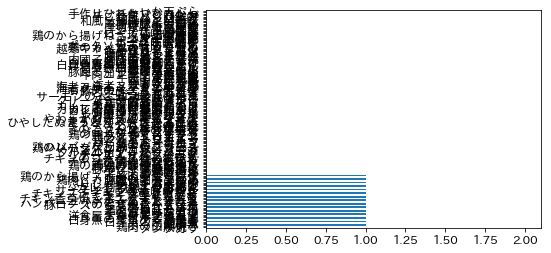

In [57]:
x.name.value_counts().plot.barh()
flds = ['name', 'responsevalue', 'pred', 'pred_std']
summ = x[flds].groupby('name', as_index=False).mean()
summ

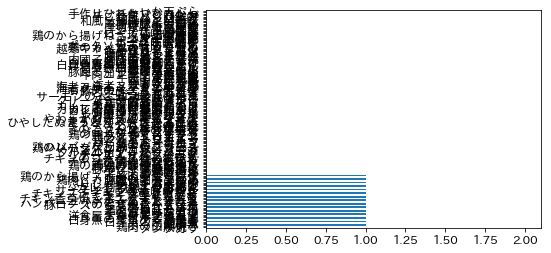

In [22]:
x.name.value_counts().plot.barh()

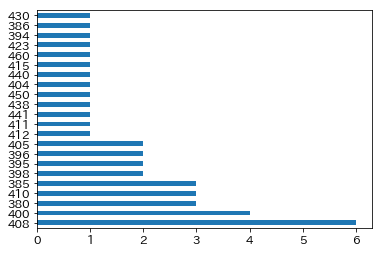

In [23]:
x.kcal.value_counts().plot.barh()

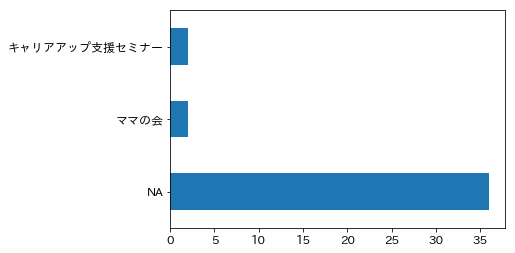

In [25]:
x.event.value_counts().plot.barh()

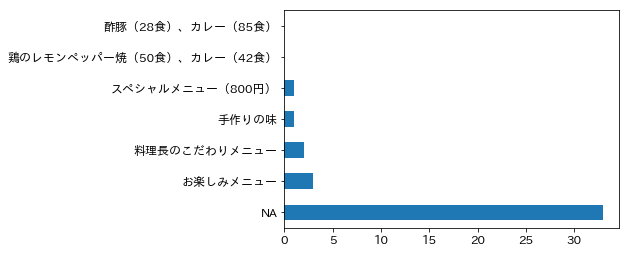

In [26]:
x.remarks.value_counts().plot.barh()

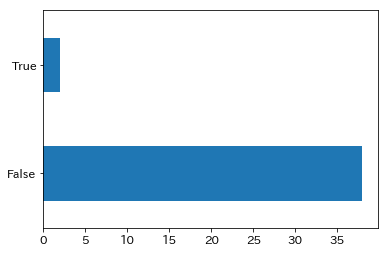

In [27]:
x.payday.value_counts().plot.barh()

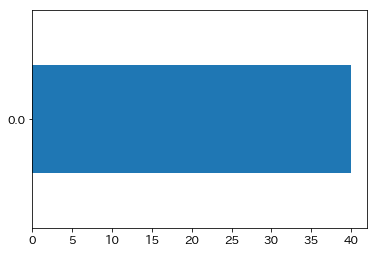

In [28]:
x.precipitation.value_counts().plot.barh()

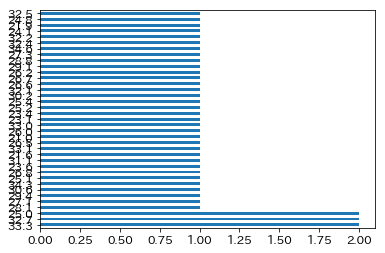

In [30]:
x.temperature.value_counts().plot.barh()

In [29]:
display_all(x)

responsevalue week  soldout             name  kcal          remarks  \
167             58    水        0            メンチカツ   441               NA   
168             60    木        0  鶏のから揚げスイートチリソース   386               NA   
169             38    金        0          豚肉の生姜焼き   380               NA   
170             75    月        1  ハンバーグ（デミきのこバター）   410               NA   
171             54    火        1         鶏肉のカレー唐揚   400               NA   
172             58    水        1           豚キムチ炒め   410               NA   
173             63    木        0  チキン香草焼きマスタードソース   415               NA   
174            129    金        0           チキンカレー   408         お楽しみメニュー   
175             45    月        0     サーモンフライ・タルタル   411               NA   
176             40    火        1           厚切ハムカツ   400               NA   
177             56    月        0      洋食屋さんのメンチカツ   396               NA   
178             53    火        1            牛スキヤキ   385               NA   
179             56    水        0    豚ロースのピザ風チーズ焼き   423     料理長のこだわりメニュー   
180             54    木        0            チキン南蛮   405               NA   
181            100    金        1            ロコモコ丼   408         お楽しみメニュー   
182             55    月        0         白身魚の南部焼き   412               NA   
183             68    火        0           キーマカレー   400               NA   
184             62    水        0          カレイの唐揚げ   410               NA   
185             56    木        0         豚肉の胡麻シャブ   396               NA   
186             39    金        0        チキンの辛味噌焼き   398               NA   
187             65    月        1          ビーフシチュー   380               NA   
188             68    火        1          名古屋味噌カツ   440            手作りの味   
189             53    水        0              親子煮   408               NA   
190             54    木        1   チキンステーキ・きのこソース   405               NA   
191             43    金        0            メンチカツ   380               NA   
192             68    月        1          鶏肉の山賊焼き   385               NA   
193             63    火        0       ハンバーグデミソース   460               NA   
194             54    水        0      ぶりレモンペッパー焼き   450               NA   
195             53    木        0         手作りチキンカツ   385               NA   
196            115    金        0           ポークカレー   408         お楽しみメニュー   
197             56    火        0         チーズメンチカツ   438               NA   
198             49    水        0         チキンフリカッセ   430     料理長のこだわりメニュー   
199             46    木        0      カレイ唐揚げ 甘酢あん   395               NA   
200             45    金        0          厚切イカフライ   400               NA   
201             29    月        0              筑前煮   395               NA   
202             59    水        1      白身魚のマスタード焼き   408               NA   
203             50    木        0          牛カルビ焼き肉   394               NA   
204             45    金        0         ランチビュッフェ   408  スペシャルメニュー（800円）   
205             56    月        1         豚肉と玉子の炒め   404               NA   
206             40    火        0     鶏肉とカシューナッツ炒め   398               NA   

             event  payday weather  precipitation  temperature  saleYear  \
167             NA   False      晴れ            0.0         30.6      2014   
168             NA   False      晴れ            0.0         32.5      2014   
169             NA   False      薄曇            0.0         32.7      2014   
170             NA   False       曇            0.0         32.7      2014   
171             NA   False      快晴            0.0         34.3      2014   
172             NA   False      快晴            0.0         34.6      2014   
173             NA   False      晴れ            0.0         32.1      2014   
174             NA    True       曇            0.0         31.1      2014   
175             NA   False      晴れ            0.0         32.4      2014   
176             NA   False       雨            0.0         29.4      2014   
177             NA   False       曇            0.0   

In [31]:
flds = ['week', 'responsevalue', 'pred', 'pred_std']
enc_summ = x[flds].groupby('week', as_index=False).mean()
enc_summ

week  responsevalue       pred   pred_std
0    月         56.125  65.056250   8.353979
1    火         55.250  58.009375   8.004492
2    水         56.125  58.178125   7.996455
3    木         54.500  57.753125   6.727437
4    金         69.250  78.606250  13.705923

In [34]:
flds = ['soldout', 'responsevalue', 'pred', 'pred_std']
enc_summ = x[flds].groupby('soldout', as_index=False).mean()
enc_summ

soldout  responsevalue      pred  pred_std
0        0      56.428571  63.66875  8.688438
1        1      62.500000  63.17500  9.585834

In [35]:
flds = ['name', 'responsevalue', 'pred', 'pred_std']
enc_summ = x[flds].groupby('name', as_index=False).mean()
enc_summ

name  responsevalue    pred   pred_std
0               いか天ぷら            NaN     NaN        NaN
1             かじきの甘辛煮            NaN     NaN        NaN
2         きのこソースハンバーグ            NaN     NaN        NaN
3           さっくりメンチカツ            NaN     NaN        NaN
4            さわら焼味噌掛け            NaN     NaN        NaN
5              さんま辛味焼            NaN     NaN        NaN
6         たっぷりベーコンフライ            NaN     NaN        NaN
7    ひやしたぬきうどん・炊き込みご飯            NaN     NaN        NaN
8         ぶりレモンペッパー焼き           54.0  57.450  10.022350
9         ますのマスタードソース            NaN     NaN        NaN
10      やわらかロースのサムジョン            NaN     NaN        NaN
11         アジ唐揚げ南蛮ソース            NaN     NaN        NaN
12              エビフライ            NaN     NaN        NaN
13          カキフライタルタル            NaN     NaN        NaN
14            カレイの唐揚げ           62.0  61.625   8.979665
15        カレイ唐揚げ 甘酢あん           46.0  55.800   4.308132
16        カレイ唐揚げ夏野菜あん            NaN     NaN        NaN
17       カレイ唐揚げ野菜あんかけ            NaN     NaN        NaN
18        カレイ唐揚げ野菜餡かけ            NaN     NaN        NaN
19          カレイ野菜あんかけ            NaN     NaN        NaN
20       カレー入りソーセージカツ            NaN     NaN        NaN
21          キスと野菜の天ぷら            NaN     NaN        NaN
22             キーマカレー           68.0  58.800   8.136953
23       クリームチーズ入りメンチ            NaN     NaN        NaN
24          ゴーヤチャンプルー            NaN     NaN        NaN
25            サバ焼味噌掛け            NaN     NaN        NaN
26     サーモンのムニエル2色ソース            NaN     NaN        NaN
27       サーモンフライ・タルタル           45.0  64.150   7.869403
28          ジャンボチキンカツ            NaN     NaN        NaN
29         ジューシーメンチカツ            NaN     NaN        NaN
..                ...            ...     ...        ...
126       豚肉と茄子のピリ辛炒め            NaN     NaN        NaN
127        豚肉のマスタード焼き            NaN     NaN        NaN
128            豚肉の生姜焼            NaN     NaN        NaN
129           豚肉の生姜焼き           38.0  56.850   5.145629
130          豚肉の胡麻シャブ           56.0  62.200   8.956004
131      越冬キャベツのメンチカツ            NaN     NaN        NaN
132                酢豚            NaN     NaN        NaN
133           酢豚orカレー            NaN     NaN        NaN
134           青梗菜牛肉炒め            NaN     NaN        NaN
135              青椒肉絲            NaN     NaN        NaN
136    鶏のから揚げねぎ塩炒めソース            NaN     NaN        NaN
137   鶏のから揚げスイートチリソース           60.0  59.675   6.878908
138       鶏のカッシュナッツ炒め            NaN     NaN        NaN
139         鶏のトマトシチュー            NaN     NaN        NaN
140           鶏のピリ辛焼き            NaN     NaN        NaN
141   鶏のレモンペッパー焼orカレー            NaN     NaN        NaN
142          鶏の味噌漬け焼き            NaN     NaN        NaN
143              鶏の唐揚            NaN     NaN        NaN
144             鶏の唐揚げ            NaN     NaN        NaN
145       鶏の唐揚げおろしソース            NaN     NaN        NaN
146         鶏の唐揚げ甘酢あん            NaN     NaN        NaN
147           鶏の塩から揚げ            NaN     NaN        NaN
148             鶏の天ぷら            NaN     NaN        NaN
149       鶏の照り焼きマスタード            NaN     NaN        NaN
150          鶏の照り焼きマヨ            NaN     NaN        NaN
151             鶏の親子煮            NaN     NaN        NaN
152            鶏チリソース            NaN     NaN        NaN
153      鶏肉とカシューナッツ炒め           40.0  59.650   9.835014
154          鶏肉のカレー唐揚           54.0  60.675  10.402854
155           鶏肉の山賊焼き           68.0  66.500  10.158740

[156 rows x 4 columns]

- NaN means name exists on training set, but NOT in validation set we set aside i.e., the last 40 samples of test set 

In [36]:
flds = ['kcal', 'responsevalue', 'pred', 'pred_std']
enc_summ = x[flds].groupby('kcal', as_index=False).mean()
enc_summ

kcal  responsevalue       pred   pred_std
0    380      48.666667  59.491667   7.092248
1    385      58.000000  61.416667   7.537671
2    386      60.000000  59.675000   6.878908
3    394      50.000000  56.625000   5.503124
4    395      37.500000  59.487500   6.074983
5    396      56.000000  63.587500   7.633330
6    398      39.500000  58.862500   8.436007
7    400      51.750000  58.662500   7.529110
8    404      56.000000  62.875000   8.167581
9    405      54.000000  56.062500   6.518009
10   408      83.500000  86.087500  17.330226
11   410      65.000000  62.183333   8.812993
12   411      45.000000  64.150000   7.869403
13   412      55.000000  65.725000   7.539852
14   415      63.000000  56.750000   8.990968
15   423      56.000000  58.325000   5.631996
16   430      49.000000  56.175000   5.253035
17   438      56.000000  55.325000   6.809506
18   440      68.000000  56.600000   7.621680
19   441      58.000000  57.800000   7.861934
20   450      54.000000  57.450000  10.022350
21   460      63.000000  56.900000   8.404761

In [37]:
flds = ['remarks', 'responsevalue', 'pred', 'pred_std']
enc_summ = x[flds].groupby('remarks', as_index=False).mean()
enc_summ

remarks  responsevalue        pred   pred_std
0                        NA      53.575758   59.643182   7.646171
1                  お楽しみメニュー     114.666667  103.850000  22.220440
2           スペシャルメニュー（800円）      45.000000   89.950000  20.814598
3                     手作りの味      68.000000   56.600000   7.621680
4              料理長のこだわりメニュー      52.500000   57.250000   5.442515
5          酢豚（28食）、カレー（85食）            NaN         NaN        NaN
6  鶏のレモンペッパー焼（50食）、カレー（42食）            NaN         NaN        NaN

In [38]:
flds = ['event', 'responsevalue', 'pred', 'pred_std']
enc_summ = x[flds].groupby('event', as_index=False).mean()
enc_summ

event  responsevalue       pred   pred_std
0             NA      59.055556  63.296528   8.916852
1  キャリアアップ支援セミナー      49.500000  73.825000  13.207299
2           ママの会      52.500000  57.250000   5.442515

In [39]:
flds = ['payday', 'responsevalue', 'pred', 'pred_std']
enc_summ = x[flds].groupby('payday', as_index=False).mean()
enc_summ

payday  responsevalue       pred   pred_std
0   False           56.5  62.444079   8.597104
1    True           91.5  83.975000  15.808165

In [40]:
flds = ['weather', 'responsevalue', 'pred', 'pred_std']
enc_summ = x[flds].groupby('weather', as_index=False).mean()
enc_summ

weather  responsevalue       pred   pred_std
0      快晴      52.800000  60.110000   8.750933
1      晴れ      61.384615  67.288462  10.722946
2       曇      60.437500  63.425000   8.483631
3      薄曇      45.666667  57.500000   5.268342
4       雨      54.666667  59.408333   7.870064
5       雪            NaN        NaN        NaN
6      雷電            NaN        NaN        NaN

In [41]:
flds = ['precipitation', 'responsevalue', 'pred', 'pred_std']
enc_summ = x[flds].groupby('precipitation', as_index=False).mean()
enc_summ

precipitation  responsevalue       pred  pred_std
0            0.0          58.25  63.520625  8.957657

In [42]:
flds = ['temperature', 'responsevalue', 'pred', 'pred_std']
enc_summ = x[flds].groupby('temperature', as_index=False).mean()
enc_summ

temperature  responsevalue      pred   pred_std
0          21.0           62.0   61.6250   8.979665
1          21.6           56.0   62.2000   8.956004
2          21.9           53.0   58.8500   6.146340
3          23.1           68.0   66.5000  10.158740
4          23.4           65.0   67.1500  11.201674
5          23.6           45.0   57.9500   5.059397
6          24.1           46.0   55.8000   4.308132
7          24.8           59.0   58.4750   7.877143
8          25.0           51.5   56.8125   7.637692
9          25.1           39.0   58.0750   7.037000
10         25.2           29.0   63.1750   7.841835
11         25.4           50.0   56.6250   5.503124
12         26.0           55.0   65.7250   7.539852
13         26.2           68.0   58.8000   8.136953
14         26.5           54.0   54.4250   7.436019
15         26.6           56.0   62.8750   8.167581
16         26.7           53.0   56.5500   8.628296
17         26.8           63.0   56.9000   8.404761
18         27.1           45.0   89.9500  20.814598
19         27.3          115.0  110.7000  23.187497
20         28.1           40.0   59.6500   9.835014
21         28.8           56.0   55.3250   6.809506
22         29.1           68.0   56.6000   7.621680
23         29.4           40.0   57.2250   6.517237
24         30.2           43.0   54.4750   4.929440
25         30.6           58.0   57.8000   7.861934
26         31.1          129.0  110.5000  21.593981
27         32.1           63.0   56.7500   8.990968
28         32.2           56.0   64.9750   6.310656
29         32.4           45.0   64.1500   7.869403
30         32.5           60.0   59.6750   6.878908
31         32.7           56.5   61.3750   6.443861
32         33.0           54.0   57.7000   5.600000
33         33.1          100.0   90.3500  21.879842
34         33.3           54.5   58.6125   5.969964
35         34.3           54.0   60.6750  10.402854
36         34.6           58.0   59.0250   9.717221

In [53]:
#'~' means negation, the following code gets rid of:
# NaN in numeric arrays, None or NaN in object arrays, NaT in datetimelike entries in 'responsevalue' column
enc_summ = enc_summ[~pd.isnull(enc_summ.responsevalue)]
enc_summ
#enc_summ.plot('week', 'responsevalue', 'barh', xlim=(0,200));

temperature  responsevalue      pred   pred_std
0          21.0           62.0   61.6250   8.979665
1          21.6           56.0   62.2000   8.956004
2          21.9           53.0   58.8500   6.146340
3          23.1           68.0   66.5000  10.158740
4          23.4           65.0   67.1500  11.201674
5          23.6           45.0   57.9500   5.059397
6          24.1           46.0   55.8000   4.308132
7          24.8           59.0   58.4750   7.877143
8          25.0           51.5   56.8125   7.637692
9          25.1           39.0   58.0750   7.037000
10         25.2           29.0   63.1750   7.841835
11         25.4           50.0   56.6250   5.503124
12         26.0           55.0   65.7250   7.539852
13         26.2           68.0   58.8000   8.136953
14         26.5           54.0   54.4250   7.436019
15         26.6           56.0   62.8750   8.167581
16         26.7           53.0   56.5500   8.628296
17         26.8           63.0   56.9000   8.404761
18         27.1           45.0   89.9500  20.814598
19         27.3          115.0  110.7000  23.187497
20         28.1           40.0   59.6500   9.835014
21         28.8           56.0   55.3250   6.809506
22         29.1           68.0   56.6000   7.621680
23         29.4           40.0   57.2250   6.517237
24         30.2           43.0   54.4750   4.929440
25         30.6           58.0   57.8000   7.861934
26         31.1          129.0  110.5000  21.593981
27         32.1           63.0   56.7500   8.990968
28         32.2           56.0   64.9750   6.310656
29         32.4           45.0   64.1500   7.869403
30         32.5           60.0   59.6750   6.878908
31         32.7           56.5   61.3750   6.443861
32         33.0           54.0   57.7000   5.600000
33         33.1          100.0   90.3500  21.879842
34         33.3           54.5   58.6125   5.969964
35         34.3           54.0   60.6750  10.402854
36         34.6           58.0   59.0250   9.717221

In [64]:
enc_summ.plot('week', 'pred', 'barh', xerr='pred_std', alpha=0.6, xlim=(0,11));

KeyError: 'week'

*Question*: Why are the predictions nearly exactly right, but the error bars are quite wide?

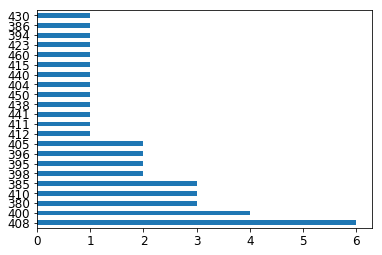

In [43]:
raw_valid.kcal.value_counts().plot.barh();

In [69]:
(summ.pred_std/summ.pred).sort_values(ascending=False)

weather
4    0.187538
6    0.159205
5    0.152635
3    0.133816
2    0.112742
dtype: float64

# Feature importance

It's not normally enough to just to know that a model can make accurate predictions - we also want to know *how* it's making predictions. The most important way to see this is with *feature importance*.

In [70]:
fi = rf_feat_importance(m, df_trn); fi[:10]

cols       imp
22    saleElapsed  0.381637
9     temperature  0.271215
15  saleDayofyear  0.107562
23        kcal_na  0.041712
14  saleDayofweek  0.035421
0            week  0.032230
12       saleWeek  0.027980
3            kcal  0.026215
13        saleDay  0.022129
2            name  0.016225

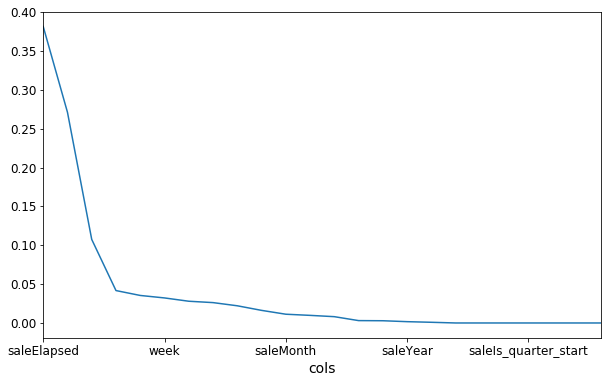

In [71]:
fi.plot('cols', 'imp', figsize=(10,6), legend=False);

In [72]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

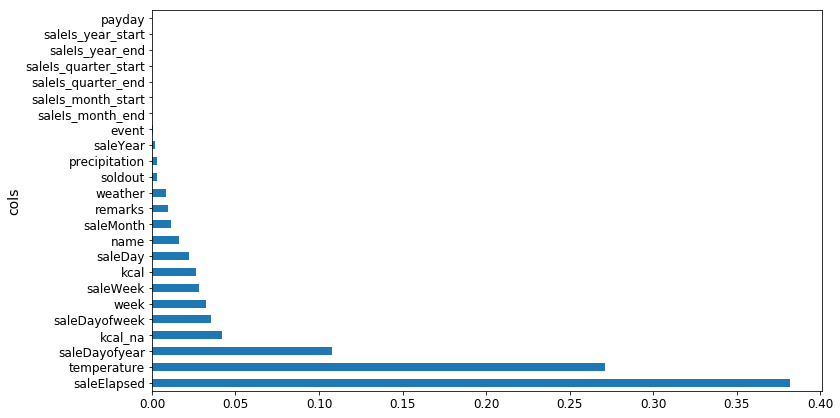

In [73]:
plot_fi(fi[:30]);

In [76]:
to_keep = fi[fi.imp>0.02].cols; len(to_keep)

9

In [77]:
df_keep = df_trn[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

In [78]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5,
                          n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[10.068267569207867, 15.965923968623564, 0.8996066642305053, 0.28191632614706597, 0.748059788750717]


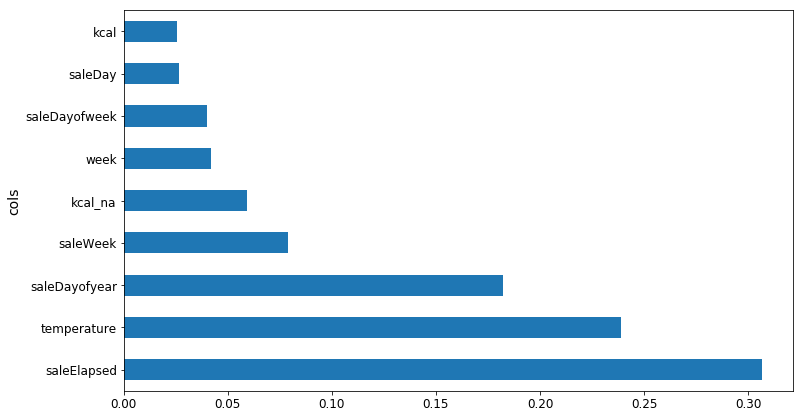

In [79]:
fi = rf_feat_importance(m, df_keep)
plot_fi(fi);

## One-hot encoding

proc_df's optional *max_n_cat* argument will turn some categorical variables into new columns.

For example, the column **ProductSize** which has 6 categories:

* Large
* Large / Medium
* Medium
* Compact
* Small
* Mini

gets turned into 6 new columns:

* ProductSize_Large
* ProductSize_Large / Medium
* ProductSize_Medium
* ProductSize_Compact
* ProductSize_Small
* ProductSize_Mini

and the column **ProductSize** gets removed.

It will only happen to columns whose number of categories is no bigger than the value of the *max_n_cat* argument.

Now some of these new columns may prove to have more important features than in the earlier situation, where all categories were in one column.

In [80]:
df_trn2, y_trn, nas = proc_df(df_raw, 'responsevalue', max_n_cat=7)
X_train, X_valid = split_vals(df_trn2, n_trn)

m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[9.032231263323142, 12.452585454042719, 0.9192048139776225, 0.5631764935660091, 0.760772313912937]


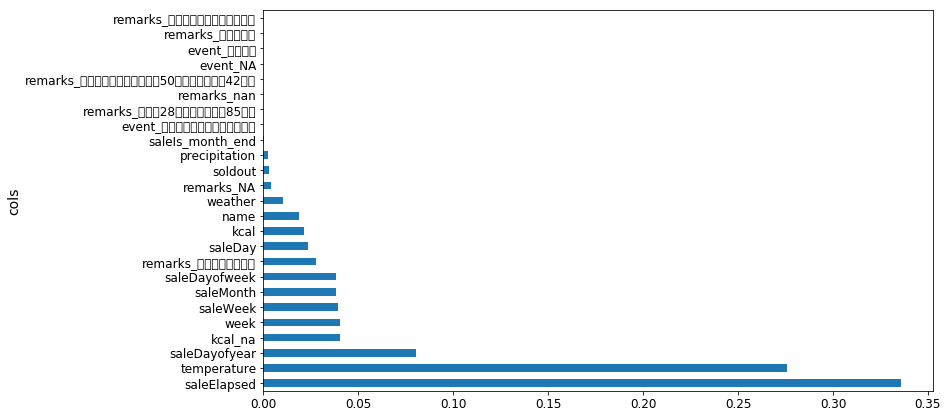

In [81]:
fi = rf_feat_importance(m, df_trn2)
plot_fi(fi[:25]);

# Removing redundant features

One thing that makes this harder to interpret is that there seem to be some variables with very similar meanings. Let's try to remove redundent features.

In [82]:
from scipy.cluster import hierarchy as hc

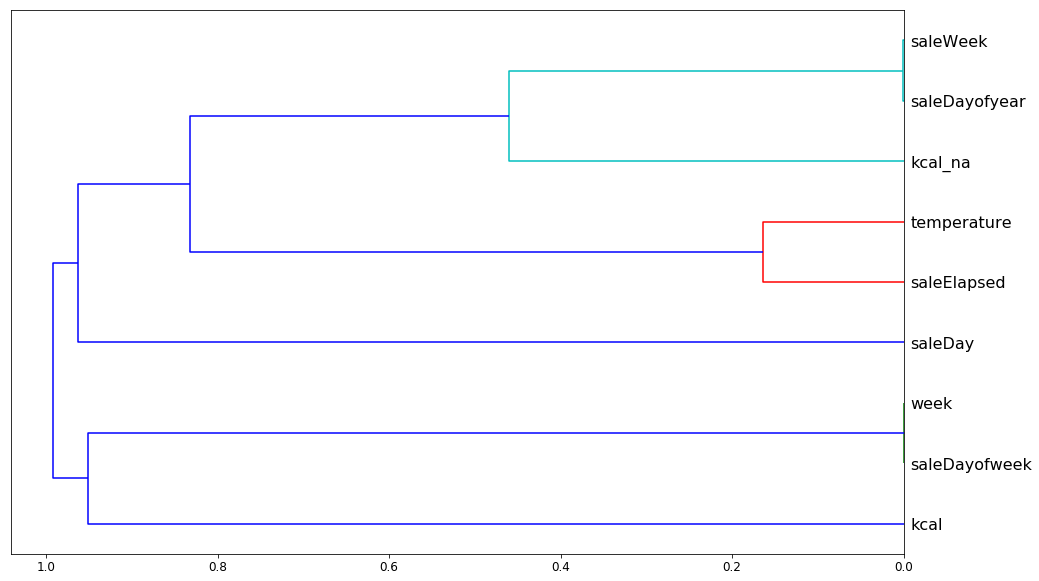

In [83]:
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

Let's try removing some of these related features to see if the model can be simplified without impacting the accuracy.

In [84]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=30, min_samples_leaf=5, max_features=0.6, n_jobs=-1, oob_score=True)
    x, _ = split_vals(df, n_trn)
    m.fit(x, y_train)
    return m.oob_score_

Here's our baseline.

In [91]:
get_oob(df_keep)
df_keep.head()

saleElapsed  temperature  saleDayofyear  kcal_na  saleDayofweek  week  \
0   1384732800         19.8            322     True              0     1   
1   1384819200         17.0            323     True              1     2   
2   1384905600         15.5            324     True              2     3   
3   1384992000         15.2            325     True              3     4   
4   1385078400         16.1            326     True              4     5   

   saleWeek  kcal  saleDay  
0        47   408       18  
1        47   408       19  
2        47   408       20  
3        47   408       21  
4        47   408       22

Now we try removing each variable one at a time.

In [92]:
for c in ('saleElapsed', 'temperature', 'saleDayofyear', 'kcal_na', 'saleDayofweek', 'week', 'saleWeek', 'kcal', 'saleDay'):
    print(c, get_oob(df_keep.drop(c, axis=1)))

saleElapsed 0.7210543470805637
temperature 0.7239829392073828
saleDayofyear 0.7218462242125132
kcal_na 0.7129835258503854
saleDayofweek 0.7061960376904969
week 0.7269273643090144
saleWeek 0.7481142127519597
kcal 0.7255342612810074
saleDay 0.7052818755207018


It looks like we can try one from each group for removal. Let's see what that does.

In [93]:
to_drop = ['saleDayofyear', 'saleElapsed', 'saleDayofweek', 'saleWeek']
get_oob(df_keep.drop(to_drop, axis=1))

0.7282143028797955

Looking good! Let's use this dataframe from here. We'll save the list of columns so we can reuse it later.

In [94]:
df_keep.drop(to_drop, axis=1, inplace=True)
X_train, X_valid = split_vals(df_keep, n_trn)

In [95]:
np.save('tmp/keep_cols.npy', np.array(df_keep.columns))

In [96]:
keep_cols = np.load('tmp/keep_cols.npy')
df_keep = df_trn[keep_cols]

And let's see how this model looks on the full dataset.

In [97]:
reset_rf_samples()

In [98]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[11.31162033550998, 15.739215608396561, 0.8732800398969214, 0.30216441996522725, 0.73286226536462]


# Partial dependence

In [ ]:
from pdpbox import pdp
from plotnine import *

In [ ]:
set_rf_samples(50000)

This next analysis will be a little easier if we use the 1-hot encoded categorical variables, so let's load them up again.

In [ ]:
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=7)
X_train, X_valid = split_vals(df_trn2, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1)
m.fit(X_train, y_train);

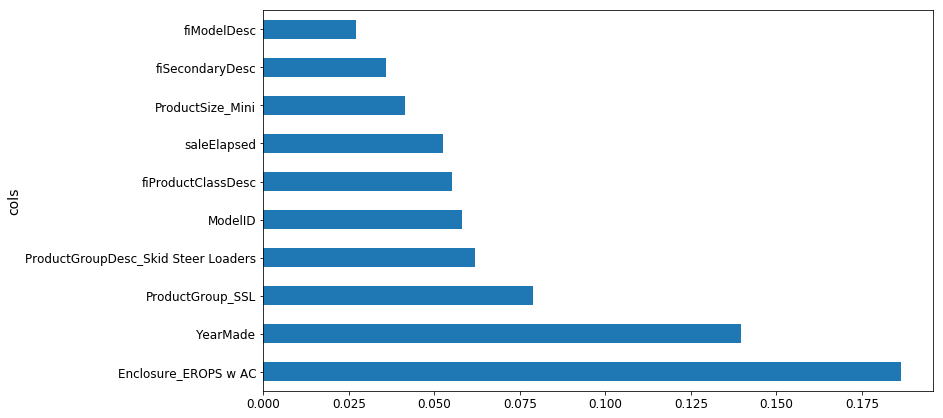

In [ ]:
plot_fi(rf_feat_importance(m, df_trn2)[:10]);

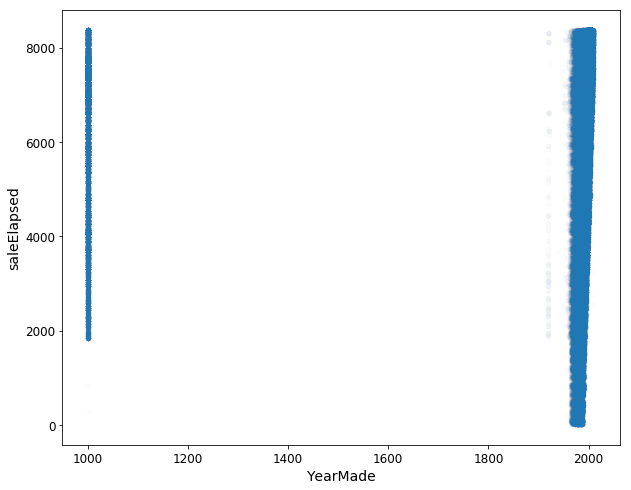

In [ ]:
df_raw.plot('YearMade', 'saleElapsed', 'scatter', alpha=0.01, figsize=(10,8));

In [ ]:
x_all = get_sample(df_raw[df_raw.YearMade>1930], 500)

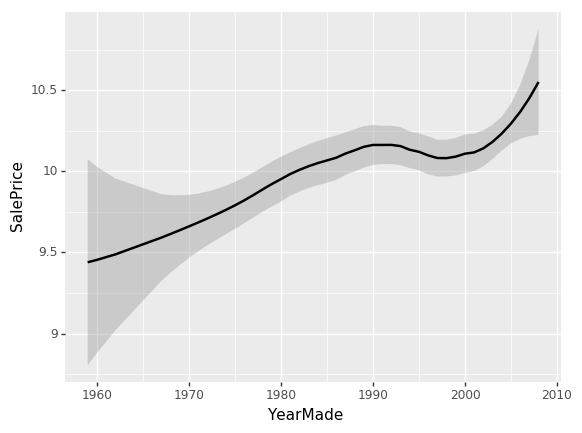

<ggplot: (8729550331912)>

In [ ]:
ggplot(x_all, aes('YearMade', 'SalePrice'))+stat_smooth(se=True, method='loess')

In [ ]:
x = get_sample(X_train[X_train.YearMade>1930], 500)

In [ ]:
def plot_pdp(feat, clusters=None, feat_name=None):
    feat_name = feat_name or feat
    p = pdp.pdp_isolate(m, x, feat)
    return pdp.pdp_plot(p, feat_name, plot_lines=True,
                        cluster=clusters is not None,
                        n_cluster_centers=clusters)

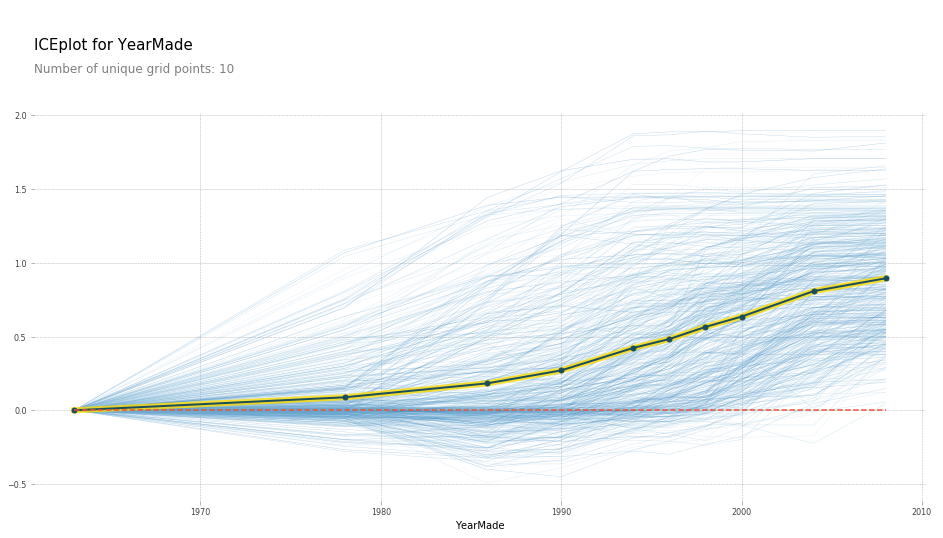

In [ ]:
plot_pdp('YearMade')

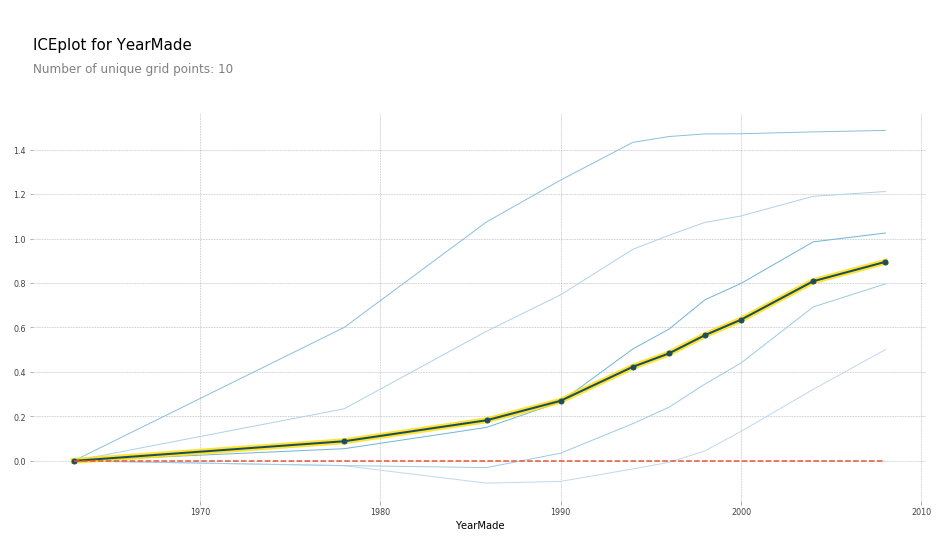

In [ ]:
plot_pdp('YearMade', clusters=5)

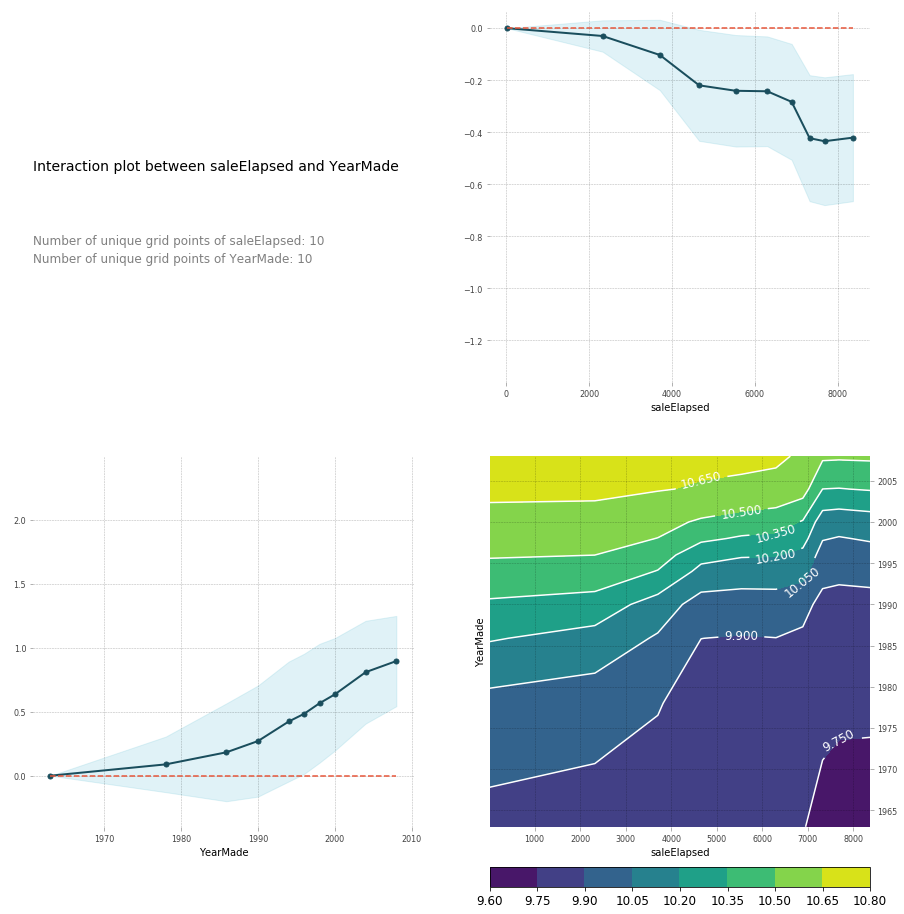

In [ ]:
feats = ['saleElapsed', 'YearMade']
p = pdp.pdp_interact(m, x, feats)
pdp.pdp_interact_plot(p, feats)

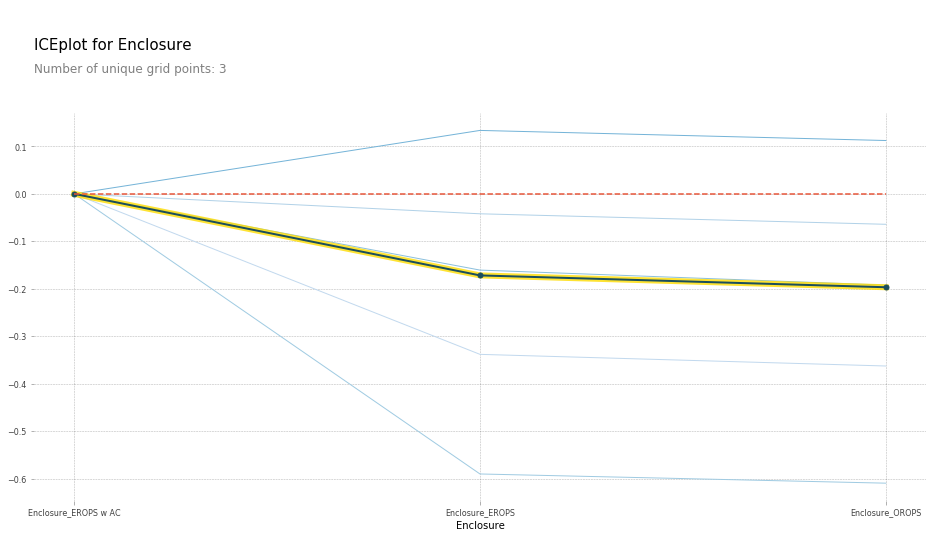

In [ ]:
plot_pdp(['Enclosure_EROPS w AC', 'Enclosure_EROPS', 'Enclosure_OROPS'], 5, 'Enclosure')

In [ ]:
df_raw.YearMade[df_raw.YearMade<1950] = 1950
df_keep['age'] = df_raw['age'] = df_raw.saleYear-df_raw.YearMade

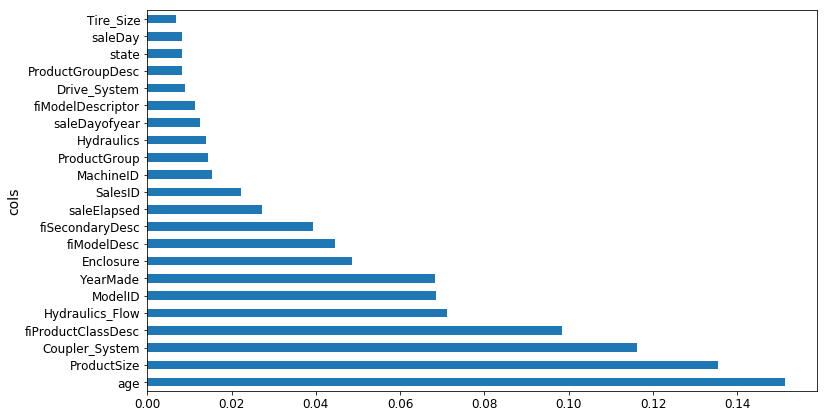

In [ ]:
X_train, X_valid = split_vals(df_keep, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1)
m.fit(X_train, y_train)
plot_fi(rf_feat_importance(m, df_keep));

# Tree interpreter

In [ ]:
from treeinterpreter import treeinterpreter as ti

In [ ]:
df_train, df_valid = split_vals(df_raw[df_keep.columns], n_trn)

In [ ]:
row = X_valid.values[None,0]; row

array([[4364751, 2300944, 665, 172, 1.0, 1999, 3726.0, 3, 3232, 1111, 0, 63, 0, 5, 17, 35, 4, 4, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 12, 0, 0, 0, 0, 0, 3, 0, 0, 0, 2, 19, 29, 3, 2, 1, 0, 0, 0, 0, 0, 2010, 9, 37,
        16, 3, 259, False, False, False, False, False, False, 7912, False, False]], dtype=object)

In [ ]:
prediction, bias, contributions = ti.predict(m, row)

In [ ]:
prediction[0], bias[0]

(9.1909688098736275, 10.10606580677884)

In [ ]:
idxs = np.argsort(contributions[0])

In [ ]:
[o for o in zip(df_keep.columns[idxs], df_valid.iloc[0][idxs], contributions[0][idxs])]

[('ProductSize', 'Mini', -0.54680742853695008),
 ('age', 11, -0.12507089451852943),
 ('fiProductClassDesc',
  'Hydraulic Excavator, Track - 3.0 to 4.0 Metric Tons',
  -0.11143111128570773),
 ('fiModelDesc', 'KX1212', -0.065155113754146801),
 ('fiSecondaryDesc', nan, -0.055237427792181749),
 ('Enclosure', 'EROPS', -0.050467175593900217),
 ('fiModelDescriptor', nan, -0.042354676935508852),
 ('saleElapsed', 7912, -0.019642242073500914),
 ('saleDay', 16, -0.012812993479652724),
 ('Tire_Size', nan, -0.0029687660942271598),
 ('SalesID', 4364751, -0.0010443985823001434),
 ('saleDayofyear', 259, -0.00086540581130196688),
 ('Drive_System', nan, 0.0015385818526195915),
 ('Hydraulics', 'Standard', 0.0022411701338458821),
 ('state', 'Ohio', 0.0037587658190299409),
 ('ProductGroupDesc', 'Track Excavators', 0.0067688906745931197),
 ('ProductGroup', 'TEX', 0.014654732626326661),
 ('MachineID', 2300944, 0.015578052196894499),
 ('Hydraulics_Flow', nan, 0.028973749866174004),
 ('ModelID', 665, 0.0383074

In [ ]:
contributions[0].sum()

-0.7383536391949419

# Extrapolation

In [99]:
df_ext = df_keep.copy()
df_ext['is_valid'] = 1
df_ext.is_valid[:n_trn] = 0
x, y, nas = proc_df(df_ext, 'is_valid')

/home/to/miniconda3/envs/signate/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [100]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

0.8164251207729468

In [101]:
fi = rf_feat_importance(m, x); fi[:10]

cols       imp
0  temperature  0.556053
3         kcal  0.257548
4      saleDay  0.129617
2         week  0.045908
1      kcal_na  0.010873

In [102]:
feats=['temperature', 'kcal', 'saleDay']

In [104]:
X_train[feats].describe()

temperature        kcal     saleDay
count   167.000000  167.000000  167.000000
mean     17.121557  404.760479   16.173653
std       8.045804   28.383817    8.498038
min       1.200000  315.000000    1.000000
25%      10.350000  394.500000    9.000000
50%      17.400000  408.000000   17.000000
75%      23.750000  424.500000   24.000000
max      33.900000  462.000000   31.000000

In [105]:
X_valid[feats].describe()

temperature        kcal    saleDay
count    40.000000   40.000000  40.000000
mean     28.147500  406.625000  16.025000
std       3.944746   18.902839   9.616992
min      21.000000  380.000000   1.000000
25%      25.075000  395.750000   7.750000
50%      27.200000  405.000000  17.500000
75%      32.250000  410.250000  25.000000
max      34.600000  460.000000  31.000000

In [106]:
x.drop(feats, axis=1, inplace=True)

In [107]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

0.8067632850241546

In [108]:
fi = rf_feat_importance(m, x); fi[:10]

cols       imp
1     week  0.590284
0  kcal_na  0.409716

In [110]:
# Set to 167 (207 samples (November 18, 2013 to September 30, 2014) - 40 test set sie)
set_rf_samples(167)

In [114]:
feats=['temperature', 'kcal_na', 'week', 'kcal', 'saleDay']

In [115]:
X_train, X_valid = split_vals(df_keep, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[11.418371834076215, 17.440042469081586, 0.8708769575453152, 0.14319495384099623, 0.7324288787926683]


In [116]:
for f in feats:
    df_subs = df_keep.drop(f, axis=1)
    X_train, X_valid = split_vals(df_subs, n_trn)
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(X_train, y_train)
    print(f)
    print_score(m)

temperature
[18.263567419482893, 36.55095820624212, 0.6696558564972325, -2.7634354612330245, 0.3783960309477089]
kcal_na
[11.93855167076447, 18.764760418983766, 0.8588442173451711, 0.00808835921867701, 0.6711581320941729]
week
[12.158458276490606, 15.215833899900012, 0.8535961811737292, 0.3478035106324969, 0.6916075039031779]
kcal
[11.5033714753116, 15.191082370739359, 0.8689473893819607, 0.3499236350728175, 0.7219935317652546]
saleDay
[11.963736071847393, 16.418773871791537, 0.8582480523322719, 0.24060386505715203, 0.7348111281545413]


In [117]:
reset_rf_samples()

In [118]:
df_subs = df_keep.drop(['temperature', 'kcal_na', 'saleDay'], axis=1)
X_train, X_valid = split_vals(df_subs, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[20.408418328860705, 43.133522837088506, 0.5875093743469925, -4.241031845734387, 0.275573825003836]


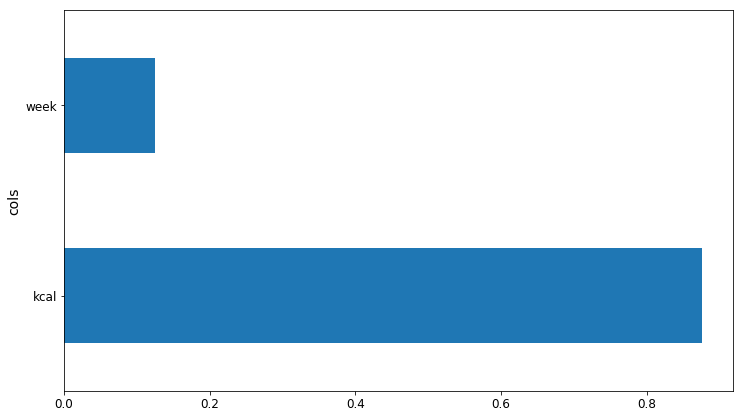

In [119]:
plot_fi(rf_feat_importance(m, X_train));

In [120]:
np.save('tmp/subs_cols.npy', np.array(df_subs.columns))

# Our final model!

In [121]:
m = RandomForestRegressor(n_estimators=160, max_features=0.5, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 203 ms, sys: 64.2 ms, total: 267 ms
Wall time: 200 ms
[15.174740761166555, 43.613587711615196, 0.771945866354373, -4.358343696830882, 0.24264678749664703]
